In [326]:
import ast
import json
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
#import plotly
#plotly.offline.init_notebook_mode(connected=True)
#import plotly.offline as py
import plotly.plotly as py
import plotly.tools as tls
import string
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from collections import Counter
import itertools

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [184]:
def read_files(nrows=None):
    """Gets the cleaned train, test datasets from the CSV or JSON files.

    If the CSV files containing the cleaned data don't exist yet, they are
    created after reading and transforming the data in the raw JSON files.

    Returns:
        train, test DataFrames.
    """
    # Create the clean dataset if it hasn't been done already
    if not all(os.path.exists(p) for p in ['data/train.csv', 'data/test.csv']):
        transform_raw_files()

    # Read the clean data files
    print('Reading CSV files...')
    train = pd.read_csv('data/train.csv', nrows=nrows, dtype=object)
    test = pd.read_csv('data/test.csv', nrows=nrows, dtype=object)

    print('Done!')

    return train, test

# The most frequent 25 columns ordered by # occurrences
CATEGORIES_TO_KEEP = [
    'Restaurants', 'Food', 'Nightlife', 'Bars', 'American (Traditional)',
    'American (New)', 'Breakfast & Brunch', 'Event Planning & Services',
    'Shopping', 'Sandwiches', 'Beauty & Spas', 'Arts & Entertainment',
    'Mexican', 'Burgers', 'Pizza', 'Italian', 'Hotels & Travel', 'Seafood',
    'Coffee & Tea', 'Japanese', 'Home Services', 'Desserts', 'Automotive',
    'Chinese', 'Sushi Bars'
]

def clean_file(df):
    """Performs cleaning on the dataset (expands columns, removes NAs, etc.).

    Args:
        df: Either the train or test DataFrame object.

    Returns:
        Cleaned DataFrame.
    """
    # There are 1301 unique categories, I chose to keep only the top 25
    print('Expanding categories...')

    # Split each row of 'categories' into a list of categories
    found_categories = [x.split(',') if isinstance(x, str) else []
                        for x in df['categories'].tolist()]

    # Strip leading/trailing spaces from these categories
    found_categories = [[c.strip() for c in l] for l in found_categories]

    # Create a DataFrame of indicator columns for the top categories
    print('Converting categories to indicator variables...')
    categories = pd.DataFrame()
    for category in tqdm(CATEGORIES_TO_KEEP):
        feature_name = 'category.{}'.format(category.replace(' ', ''))
        categories[feature_name] = [1 if category in sublist else 0
                                    for sublist in found_categories]

    # Create an "Other" column for the rest of the categories
    categories['category.Other'] = 1 - np.clip(categories.sum(axis=1), 0, 1)

    # Merge the categorical indicator features with the main DataFrame
    df = df.drop('categories', axis=1).join(categories)

    # Drop attributes for now since it takes a long time to read
    df.drop('attributes', axis=1, inplace=True)

    return df

In [261]:
# Load the first `nrows` lines of train, test
train, test = read_files(nrows=100000)

In [289]:
train_new = clean_file(train)

In [290]:
#see the amount of each category
train_new.iloc[:,13:].sum().sort_values(ascending=False)

category.Food                      21055
category.Nightlife                 18290
category.Bars                      16343
category.American(New)             13477
category.American(Traditional)     10776
category.Breakfast&Brunch          10678
category.Shopping                   8315
category.Sandwiches                 7185
category.EventPlanning&Services     6684
category.Mexican                    6643
category.Other                      6297
category.Burgers                    6062
category.Beauty&Spas                5987
category.Pizza                      5866
category.Coffee&Tea                 5734
category.Arts&Entertainment         5566
category.Italian                    5256
category.Automotive                 4738
category.Hotels&Travel              4698
category.Chinese                    4395
category.Seafood                    4373
category.Japanese                   4150
category.HomeServices               4125
category.Desserts                   3817
category.SushiBa

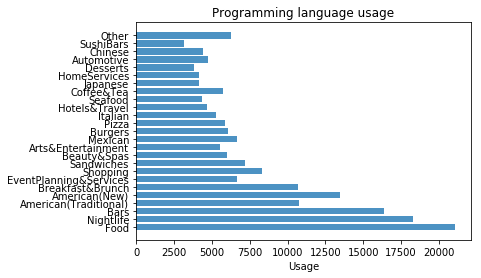

In [266]:
name = []
for x in list(train_new)[13:]:
    x=str(x)
    name.append(x.replace('category.',''))

y_pos = np.arange(len(name))
plt.barh(y_pos, train_new.iloc[:,13:].sum(), align='center', alpha=0.8)
plt.yticks(y_pos, name)
plt.xlabel('Usage')
plt.title('Programming language usage')

plt.show()

In [288]:
(train_new.iloc[:,13:].sum()).T

category.Food                         460
category.Nightlife                    512
category.Bars                         512
category.American(Traditional)          0
category.American(New)                 76
category.Breakfast&Brunch             532
category.EventPlanning&Services        48
category.Shopping                       7
category.Sandwiches                     0
category.Beauty&Spas                    0
category.Arts&Entertainment             6
category.Mexican                       28
category.Burgers                        0
category.Pizza                          0
category.Italian                        1
category.Hotels&Travel                  0
category.Seafood                      500
category.Coffee&Tea                     0
category.Japanese                     838
category.HomeServices                   0
category.Desserts                      35
category.Automotive                     0
category.Chinese                     4395
category.SushiBars                

In [291]:
train_new = train_new.loc[(train_new['category.Chinese'] == 1)]  #only select 'shopping' business , we could select a specif location
train_new['text_length'] = train_new['text'].apply(lambda x: len(x.split(" ")))  #get the counts of words in each review

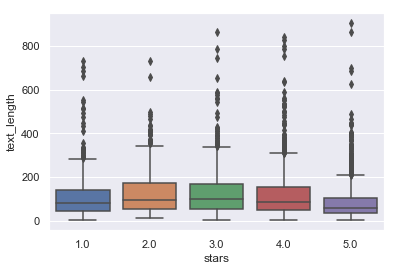

In [292]:
#no obvious relationship between stars & text_length
sns.set(style="darkgrid")
sns.boxplot(x='stars', y='text_length', data=train_new)

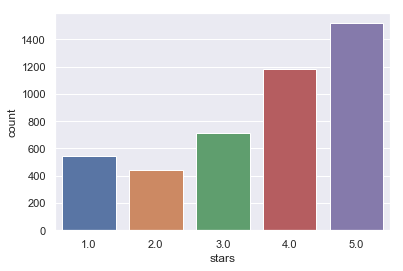

In [284]:
#5 stars is the most
ax = sns.countplot(x="stars", data=train_new)

In [293]:
#ignore the '3' for now
train_new2 = train_new.loc[(train_new['stars'] == '1.0') | (train_new['stars'] == '2.0') | (train_new['stars'] == '4.0') | (train_new['stars'] == '5.0')]
train_new2.shape

(3685, 39)

In [295]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [296]:
train_new2['text_clean'] = train_new2['text'].apply(lambda x: text_process(x)) # take a while

In [368]:
def get_wordnet_pos(treebank_tag):
    '''
    convert speach of a word in wordnet to a single alphabet
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [448]:
def words_counts_pos(df):
    '''
    Judge the speech of each word based on the sentence it exists, 
    count the frequency of words & speech,
    and simplify the notation of the speech by using get_wordnet_pos
    
    output a frequency counting data frame
    '''
    df['pos_judge'] = df['text_clean'].apply(lambda x: nltk.pos_tag(x))
    words = pd.DataFrame(data=Counter(list(itertools.chain.from_iterable(df['pos_judge']))).most_common(),columns=['tuple','counts'])
    words2 = pd.DataFrame(data=list(words[words.columns[0]]),columns=['word','POS'])
    words2['pos'] = words2['POS'].apply(lambda x: get_wordnet_pos(x))
    words2.drop('POS',axis=1, inplace=True)
    
    words = pd.concat([words2.reset_index(drop=True), words], axis=1)
    words.drop('tuple',axis=1, inplace=True)
    
    return words

In [454]:
good = train_new2[(train_new2['stars'] == '4.0') | (train_new2['stars'] == '5.0')][['stars','text_clean']]
good = words_counts_pos(good) #takes a while

In [462]:
good.head(10)

,word,pos,counts
0,food,n,2329
1,good,a,1605
2,place,n,1482
3,great,a,970
4,like,,801
5,service,n,782
6,time,n,741
7,really,r,686
8,restaurant,n,635
9,Chinese,a,635


In [458]:
bad = train_new2[(train_new2['stars'] == '1.0') | (train_new2['stars'] == '2.0')][['stars','text_clean']]
bad = words_counts_pos(bad) #takes a while

In [463]:
bad.head(10)

,word,pos,counts
0,food,n,1057
1,place,n,519
2,like,,443
3,order,n,417
4,good,a,410
5,service,n,393
6,would,,339
7,one,,326
8,time,n,316
9,us,,307


In [ ]:
#to do:
#delete frequent words shows in all "stars"
#the judge of pos for words could be improved: 
#     1. based on original sentence instead of the cleaned one;
#     2. some of the words like "like", "would" are without pos

#my question:
# there is only 'others' in the new version of csv file, no other category like 'Food', 'Hotel'